In [1]:
import enefit
import pandas as pd
from datetime import datetime
import statistics

In [2]:
# pulling in data
trainingData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv");
clientData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/client.csv");
elecPriceData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv");
foreWeatherData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv");
gasPriceData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv");
histWeatherData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv");
weatherToCountyMap = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv");

In [3]:
# common variables
datetimeColName = 'datetime'
timeColName = 'time'
date_time_format = '%Y-%m-%d %H:%M:%S'
time_format = '%H'
date_format = '%Y-%m-%d'

In [4]:
# sorting training data by time from datetime column
trainingDataSortedByTime = trainingData.copy()
def func(row):
    timeStamp = datetime.strptime(row[datetimeColName], date_time_format)
    return int(timeStamp.strftime(time_format))

trainingDataSortedByTime[timeColName] = trainingDataSortedByTime.apply(func, axis=1)
trainingDataSortedByTime = trainingDataSortedByTime.sort_values(timeColName)
trainingDataSortedByTime = trainingDataSortedByTime.reset_index(drop=True)

<Axes: xlabel='time'>

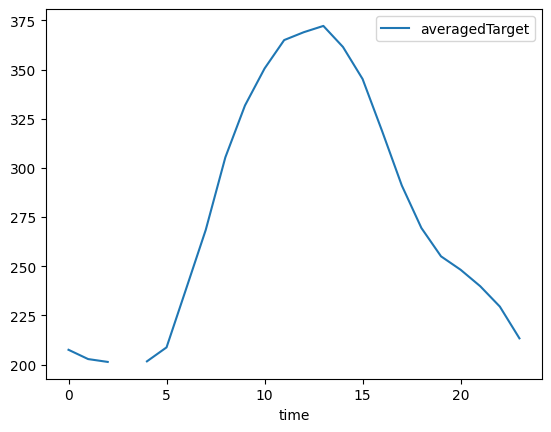

In [5]:
# averages of target consumption/production for all counties across the day
averagedData = pd.DataFrame(columns=[timeColName, 'averagedTarget'])

rowIndex = 0
while rowIndex < len(trainingDataSortedByTime):
    timeStamp = trainingDataSortedByTime['time'][rowIndex]
    endRowIndex = rowIndex
    while endRowIndex < len(trainingDataSortedByTime) and trainingDataSortedByTime['time'][endRowIndex] == timeStamp:
        endRowIndex += 1
    average = statistics.mean(trainingDataSortedByTime['target'][rowIndex:endRowIndex])
    newRow = [{timeColName:timeStamp, 'averagedTarget': average}]
    averagedData = pd.concat([averagedData, pd.DataFrame(newRow)], ignore_index=True)
    rowIndex = endRowIndex

averagedData.plot(x=timeColName, y='averagedTarget', style='-')

In [6]:
# compare forecasted gas prices to consumption on that day
totalConsumption = pd.DataFrame(columns=[datetimeColName, 'totalConsumption', 'averagedConsumption'])
trainingDataConsumptionData = trainingData.copy()

trainingDataConsumptionData = trainingDataConsumptionData.drop(trainingDataConsumptionData[trainingDataConsumptionData['is_consumption'] == 0].index)

def func(row):
    timeStamp = datetime.strptime(row[datetimeColName], date_time_format)
    return timeStamp.strftime(date_format)

trainingDataConsumptionData[datetimeColName] = trainingDataConsumptionData.apply(func, axis=1)

trainingDataConsumptionData = trainingDataConsumptionData.sort_values(datetimeColName)
trainingDataConsumptionData = trainingDataConsumptionData.reset_index(drop=True)

rowIndex = 0
while rowIndex < len(trainingDataConsumptionData):
    timeStamp = trainingDataConsumptionData[datetimeColName][rowIndex]
    endRowIndex = rowIndex
    while endRowIndex < len(trainingDataConsumptionData) and trainingDataConsumptionData[datetimeColName][endRowIndex] == timeStamp:
        endRowIndex += 1
    average = statistics.mean(trainingDataConsumptionData['target'][rowIndex:endRowIndex])
    totalCons = sum(trainingDataConsumptionData['target'][rowIndex:endRowIndex])
    newRow = [{datetimeColName:timeStamp, 'totalConsumption': totalCons, 'averagedConsumption': average}]
    totalConsumption = pd.concat([totalConsumption, pd.DataFrame(newRow)], ignore_index=True)
    rowIndex = endRowIndex

<Axes: xlabel='forecast_date'>

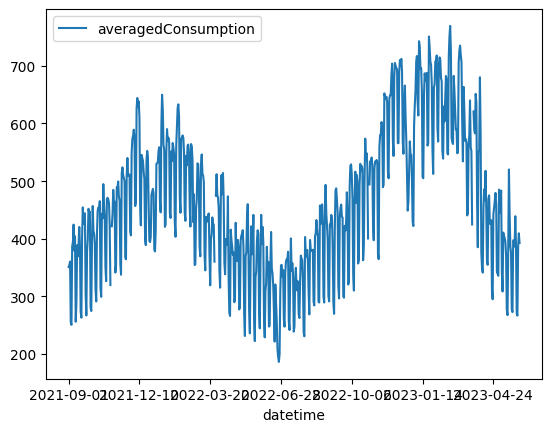

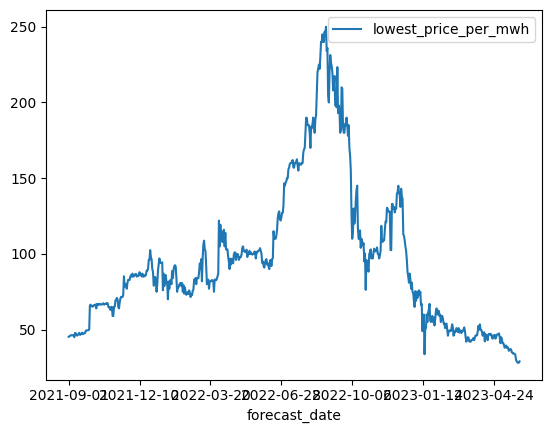

In [7]:
totalConsumption.plot(x='datetime', y='averagedConsumption', style='-')
gasPriceData.plot(x='forecast_date',y='lowest_price_per_mwh', style='-')